# Moov AI - Data science test 

Objective of this notebook is to answer **Question 3**

In [62]:
# Import des données et des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

# Import xgboost and sklearn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split

In [63]:
# Import csv
df = pd.read_csv(r'/Users/philippebeliveau/Desktop/Notebook/Moov AI/stores_sales_forecasting.csv', encoding='ISO-8859-1')

# Transform 'Order Date' and 'Ship Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date']) 

# Transform the postal code in a categorical variable
df['Postal Code'] = df['Postal Code'].astype('str')
df['Row ID'] = df['Row ID'].astype('str')

print(f"Shape of the dataset: {df.shape}")
display(df.head(5).style.set_sticky().set_properties(**{'overflow-x': 'auto'}))

df = df.sort_values('Order Date')

Shape of the dataset: (2121, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960000,2,0.000000,41.913600
1,2,CA-2016-152156,2016-11-08 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.940000,3,0.000000,219.582000
2,4,US-2015-108966,2015-10-11 00:00:00,2015-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577500,5,0.450000,-383.031000
3,6,CA-2014-115812,2014-06-09 00:00:00,2014-06-14 00:00:00,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,"Eldon Expressions Wood and Plastic Desk Accessories, Cherry Wood",48.860000,7,0.000000,14.169400
4,11,CA-2014-115812,2014-06-09 00:00:00,2014-06-14 00:00:00,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.184000,9,0.200000,85.309200


Assigning rows at every possible date between Order_date min and max

In [64]:
def adjust_dataset_for_daily_entries(df, date_col):
    """Ensures that the dataset has a row for every single day, filling missing days with NaN values."""
    df[date_col] = pd.to_datetime(df[date_col])
    all_dates = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D')
    
    # Ensure all columns are retained, filling missing values with NaN
    full_df = pd.DataFrame(all_dates, columns=[date_col])
    df = full_df.merge(df, on=date_col, how='left')
    
    return df

df = adjust_dataset_for_daily_entries(df, 'Order Date')

In [65]:
# Print the number of nan values for the sales column 
print(f"Number of NaN values in the 'Sales' column: {df['Sales'].isna().sum()}")
print(f"Number of days in the dataset: {df['Order Date'].nunique()}")
# Calculate the number of days with missing sales values
missing_sales_days = df['Sales'].isna().sum()
# Calculate the percentage of days with missing sales values
missing_sales_percentage = missing_sales_days / df['Order Date'].nunique() * 100
print(f"Percentage of days with missing sales values: {missing_sales_percentage:.2f}%")

Number of NaN values in the 'Sales' column: 566
Number of days in the dataset: 1455
Percentage of days with missing sales values: 38.90%


This tells me that I should change the frequency of my time series

In [66]:
# Change my frequency from daily to weekly and give me the statistics of the na values
df_weekly = df.resample('W', on='Order Date').sum(numeric_only=True).reset_index()
print(f"Number of NaN values in the 'Sales' column: {df_weekly['Sales'].isna().sum()}")
print(f"Number of weeks in the dataset: {df_weekly['Sales'].shape[0]}")
# Calculate the number of weeks with missing sales values
missing_sales_weeks = df_weekly['Sales'].isna().sum()
# Calculate the percentage of weeks with missing sales values
missing_sales_percentage = missing_sales_weeks / df_weekly['Sales'].shape[0] * 100

print(f"Percentage of weeks with missing sales values: {missing_sales_percentage:.2f}%")

Number of NaN values in the 'Sales' column: 0
Number of weeks in the dataset: 208
Percentage of weeks with missing sales values: 0.00%


# Question #3 : Solution ML
Décris l'approche ML que tu as utilisé pour prévoir les ventes. Pourquoi as-tu choisi cette
approche? Quels sont les avantages et les inconvénients de cette approche? 

- Unsupervised for recommendation 


## ARIMA(X)

## Lightgbm

In [72]:
import pandas as pd

# Assurez-vous que la colonne de date est de type datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Créer une colonne 'week' à partir de la colonne de date, mais conserver la colonne de date d'origine
df['week'] = df['Order Date'].dt.isocalendar().week
# Créer une colonne 'week_order_date' à partir de la colonne de date
df['week_order_date'] = df['Order Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Agréger au niveau hebdomadaire
df_weekly = df.groupby(['week', 'week_order_date', 'Region']).agg({
    'Sales': 'sum', 
    'Discount': 'mean'
}).reset_index()

# Créer des caractéristiques temporelles
df_weekly['sales_lag_1'] = df_weekly.groupby('Region')['Sales'].shift(1)
df_weekly['sales_lag_2'] = df_weekly.groupby('Region')['Sales'].shift(2)
df_weekly['sales_lag_4'] = df_weekly.groupby('Region')['Sales'].shift(4)

# Moyenne mobile
df_weekly['sales_rolling_mean_4w'] = df_weekly.groupby('Region')['Sales'].shift(1).rolling(window=4).mean()

# Caractéristiques temporelles basées sur le temps
df_weekly['month'] = df_weekly['week'].apply(lambda x: (x % 12) + 1)  # Effet mensuel approximatif
df_weekly['quarter'] = df_weekly['week'].apply(lambda x: (x % 4) + 1)  # Effet trimestriel approximatif

# Caractéristiques de délai de temps
df['Order Ship Delta'] = (df['Ship Date'] - df['Order Date']).dt.days

df_weekly.sort_values('week_order_date', inplace=True)
df_weekly

,week,week_order_date,Region,Sales,Discount,sales_lag_1,sales_lag_2,sales_lag_4,sales_rolling_mean_4w,month,quarter
9,2,2014-01-06,Central,76.7280,0.600,913.430,1588.9560,NaN,675.65400,3,3
11,2,2014-01-06,South,2625.7600,0.000,192.220,NaN,NaN,306.39700,3,3
10,2,2014-01-06,East,9.9400,0.000,15.168,3560.7420,NaN,655.58100,3,3
20,3,2014-01-13,West,515.4690,0.425,61.584,892.9800,95.460,243.60475,4,4
18,3,2014-01-13,East,189.0640,0.350,37.680,559.3790,9.940,824.88675,4,4
...,...,...,...,...,...,...,...,...,...,...,...
659,51,2017-12-18,West,1268.6810,0.325,3948.249,332.3960,447.772,2545.33425,4,4
671,52,2017-12-25,Central,203.1528,0.455,2122.662,1241.9312,2721.880,2389.29605,5,1
672,52,2017-12-25,East,830.1400,0.200,432.622,3092.6110,1900.982,2186.96875,5,1
673,52,2017-12-25,South,2093.0200,0.040,460.336,64.7840,1221.910,1528.90000,5,1


Train the model

In [73]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Définir les caractéristiques et la variable cible
features = ['Region', 'sales_lag_1', 'sales_lag_2', 'sales_lag_4', 'sales_rolling_mean_4w', 'month', 'quarter', 'Discount']
X = df_weekly[features]
y = df_weekly['Sales']

# Définir la date de coupure pour diviser les données en ensembles d'entraînement et de test
cutoff_date = '2017-01-01'

# Diviser les données en ensembles d'entraînement et de test en respectant l'ordre chronologique
X_train = X[df_weekly['week_order_date'] < cutoff_date]
X_test = X[df_weekly['week_order_date'] >= cutoff_date]
y_train = y[df_weekly['week_order_date'] < cutoff_date]
y_test = y[df_weekly['week_order_date'] >= cutoff_date]

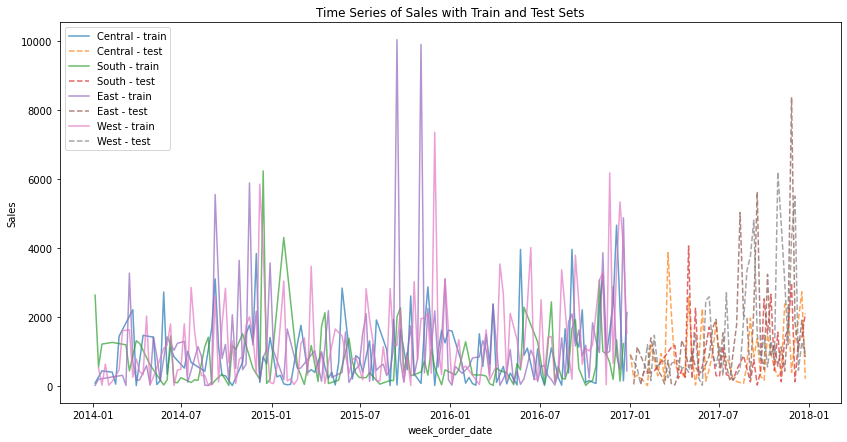

In [79]:
import matplotlib.pyplot as plt

# Ajouter une colonne pour indiquer si la donnée est dans l'ensemble d'entraînement ou de test
cutoff_date = pd.Timestamp(cutoff_date)  # Convert cutoff_date to a pandas Timestamp object
df_weekly['set'] = ['train' if date < cutoff_date else 'test' for date in df_weekly['week_order_date']]

# Tracer la série temporelle
plt.figure(figsize=(14, 7))
for region in df_weekly['Region'].unique():
    df_region = df_weekly[df_weekly['Region'] == region]
    plt.plot(df_region[df_region['set'] == 'train']['week_order_date'], df_region[df_region['set'] == 'train']['Sales'], label=f'{region} - train', alpha=0.7)
    plt.plot(df_region[df_region['set'] == 'test']['week_order_date'], df_region[df_region['set'] == 'test']['Sales'], label=f'{region} - test', alpha=0.7, linestyle='--')

plt.xlabel('week_order_date')
plt.ylabel('Sales')
plt.title('Time Series of Sales with Train and Test Sets')
plt.legend()
plt.show()

In [ ]:

# Entraîner LightGBM
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=7)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=True)

# Prédire les ventes pour l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Recursive forecasting

In [ ]:
future_steps = 4  # Number of weeks to predict
last_known_data = X_test.iloc[-1]  # Start from last known observation
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_known_data.values.reshape(1, -1))[0]
    future_predictions.append(pred)
    
    # Shift lags forward and insert new prediction
    last_known_data = last_known_data.shift(-1)
    last_known_data['sales_lag_1'] = pred

print("Predicted sales for next 4 weeks:", future_predictions)
